In [7]:
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

pd.set_option('display.max_row',None)
pd.set_option('display.max_columns',None)

In [10]:
plt.style.use('seaborn-v0_8')

In [2]:
cours = 'BTC-EUR'
actif = yf.Ticker(cours)
hist = actif.history(period="max",interval='1d')

## Global View 

In [3]:
hist['Close'].describe()

count     3533.000000
mean     14517.953274
std      16062.574339
min        151.152512
25%        963.173462
50%       7708.179688
75%      25085.046875
max      66723.851562
Name: Close, dtype: float64

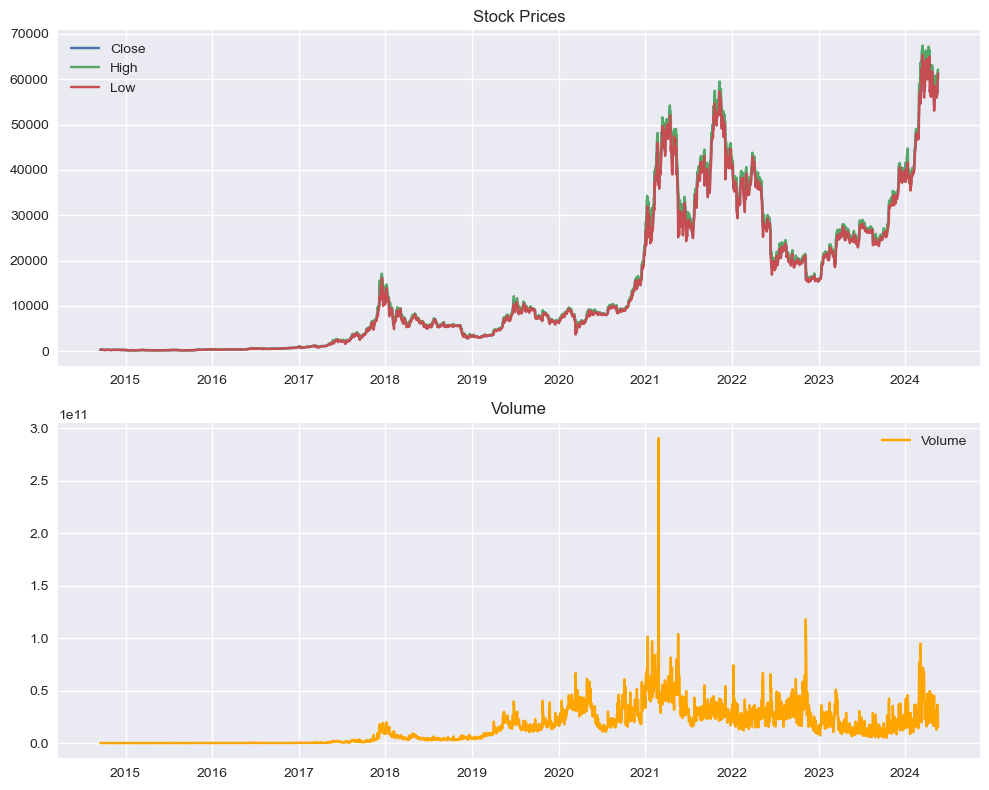

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(hist['Close'], label='Close')
plt.plot(hist['High'], label='High')
plt.plot(hist['Low'], label='Low')
plt.legend()
plt.title('Stock Prices')


plt.subplot(2, 1, 2)
plt.plot(hist['Volume'], label='Volume', color='orange')
plt.legend()
plt.title('Volume')

plt.tight_layout()
plt.show()

## Indicators

### MinMax by temporality resample

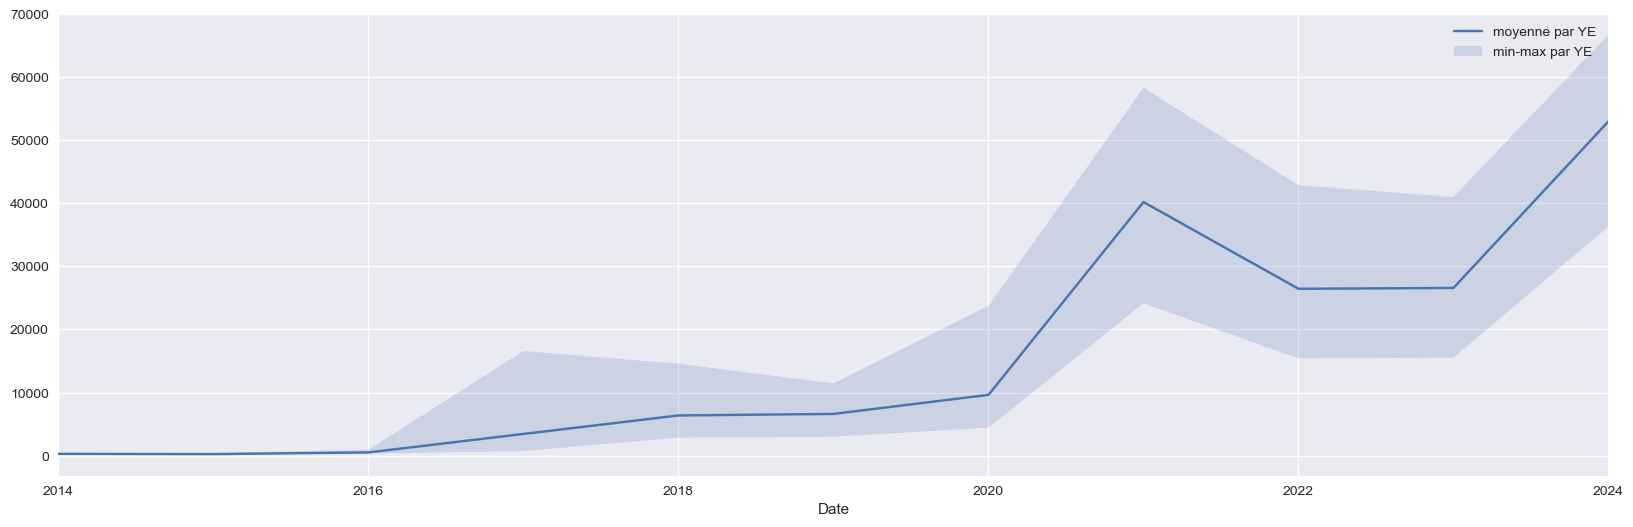

In [48]:
temporality = 'YE'

m = hist['Close'].resample(temporality).agg(['mean', 'std', 'min', 'max'])

plt.figure(figsize=(20,6))
m['mean'].plot(label=f'moyenne par {temporality}')
plt.fill_between(m.index, m['max'], m['min'], alpha=0.2, label='min-max par '+ temporality)
 
plt.legend()
plt.show()

### MA-Moving Average

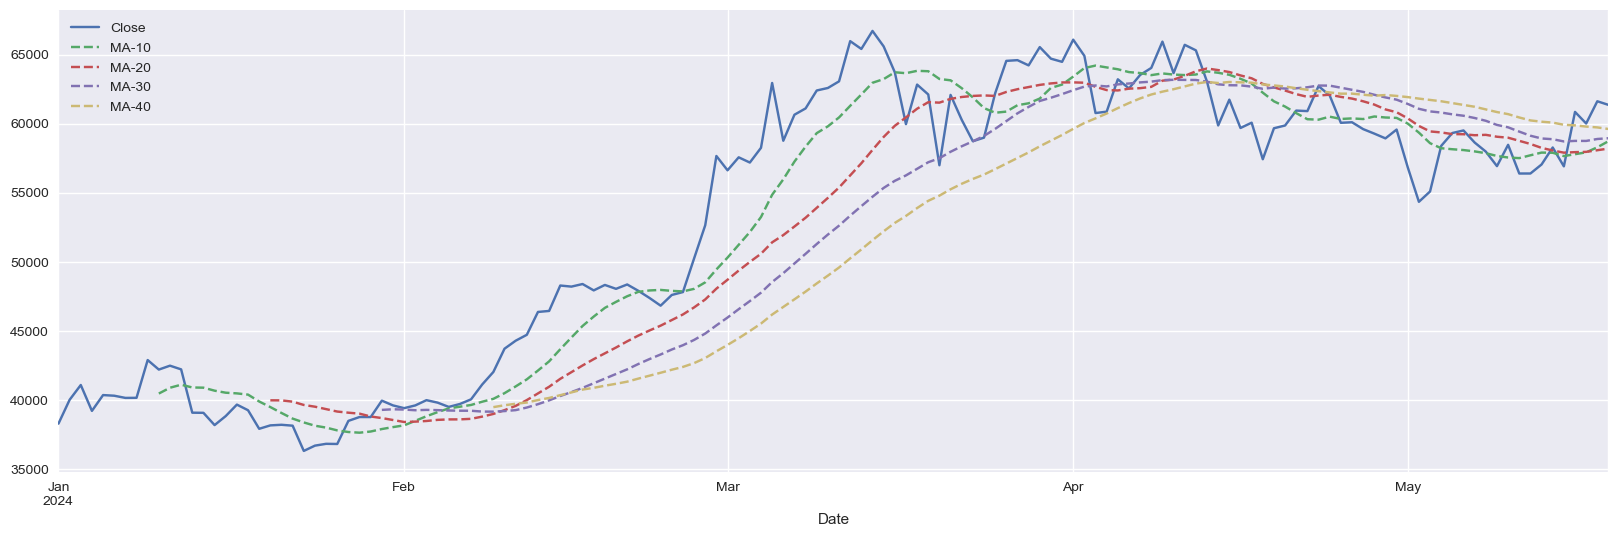

In [81]:
mask = hist.loc['2024']
plt.figure(figsize=(20,6))
mask["Close"].plot(label="Close")
for window in range(1,5):
    step = 10*window 
    mask["Close"].rolling(window=step).mean().plot(ls='--',label=f'MA-{step}')


plt.legend()
plt.show()

### EMA-Exponential moving average

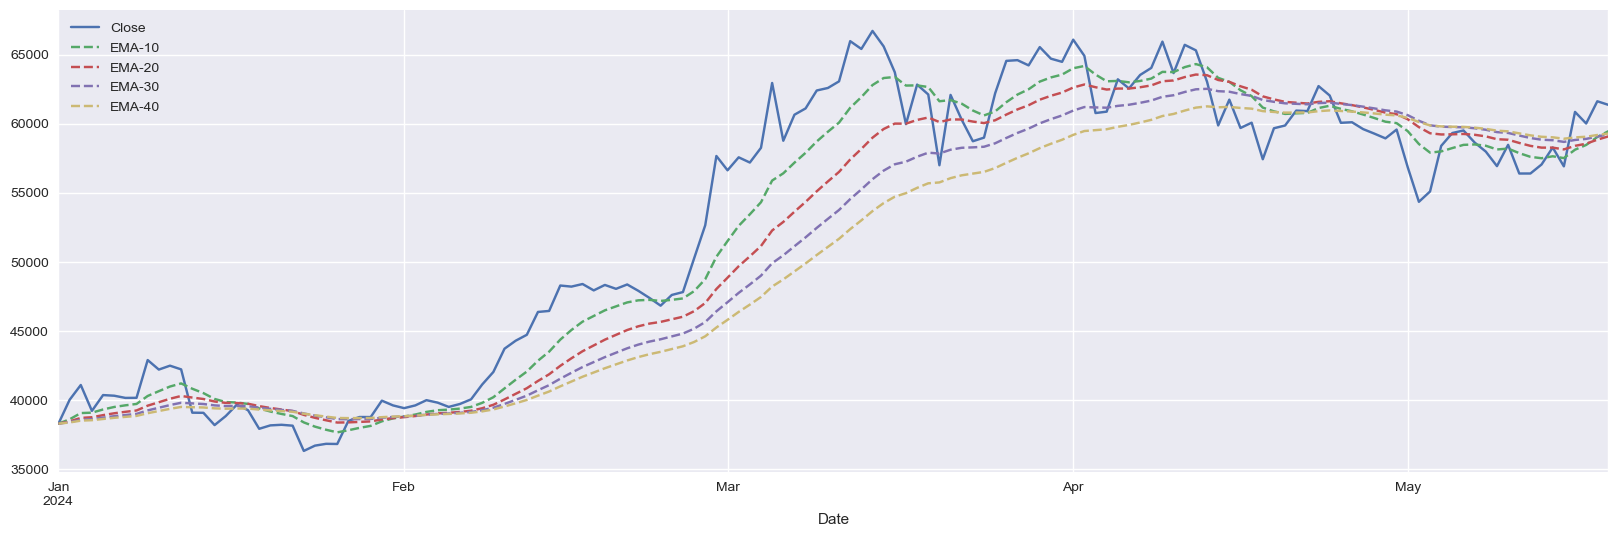

In [102]:
# Filter data for the year 2024
mask = hist.loc['2024']

plt.figure(figsize=(20, 6))

# Plot the closing prices
mask["Close"].plot(label="Close")

# Calculate and plot the EMA for different windows
for window in range(1, 5):
    step = 10 * window
    mask["Close"].ewm(span=step, adjust=False).mean().plot(ls='--', label=f'EMA-{step}')

# Display the legend
plt.legend()
plt.show()

### Right Normalization 

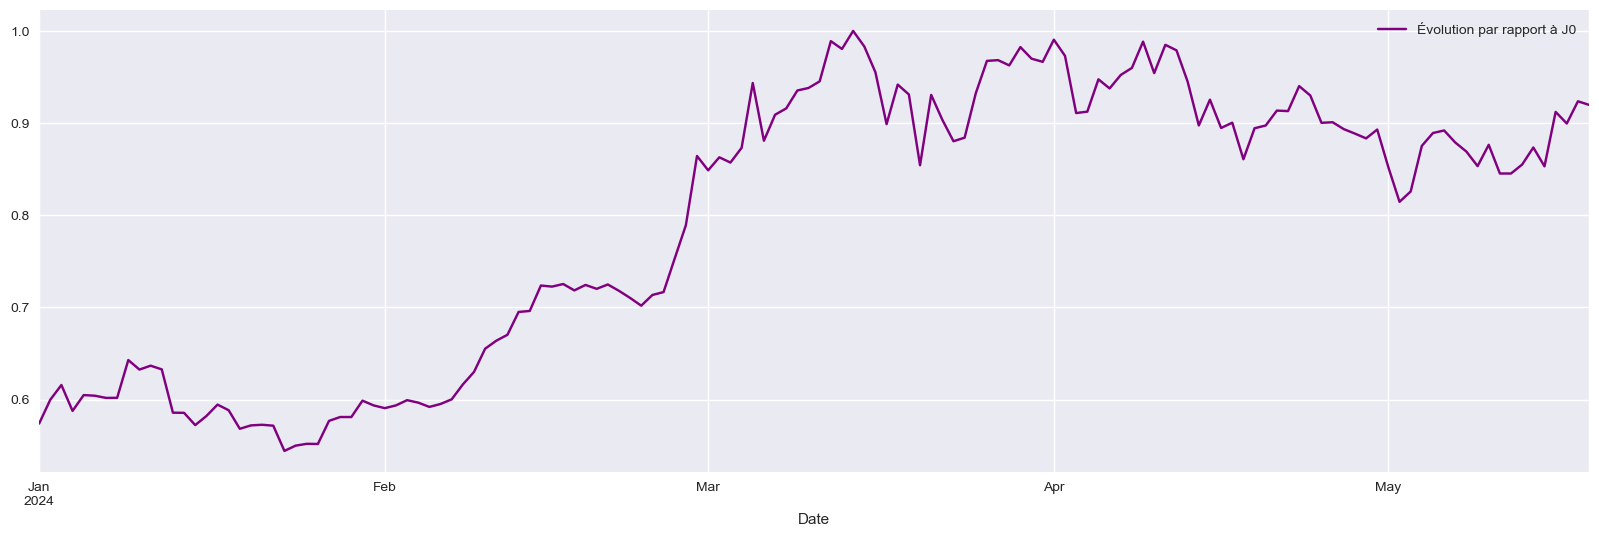

In [72]:
plt.figure(figsize=(20,6))
(mask['Close']/mask['Close'].max()).plot(label='Évolution par rapport à J0',color='purple')
plt.legend()
plt.show()

### Cumulative return

<Axes: xlabel='Date'>

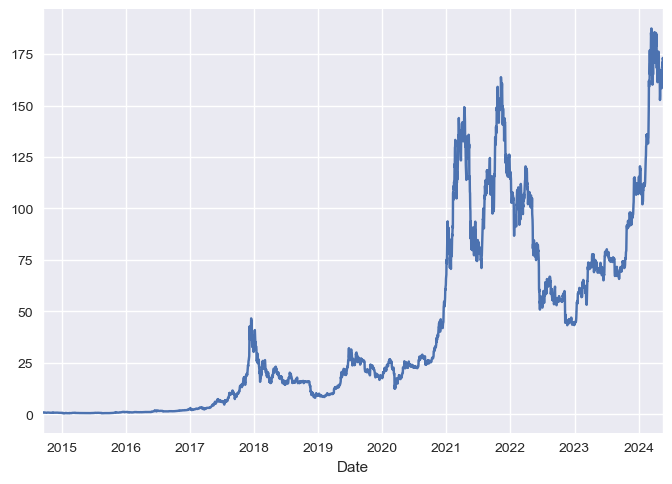

In [71]:
(1+(hist['Close'].pct_change())).cumprod().plot()

### Stochastic Indicator 

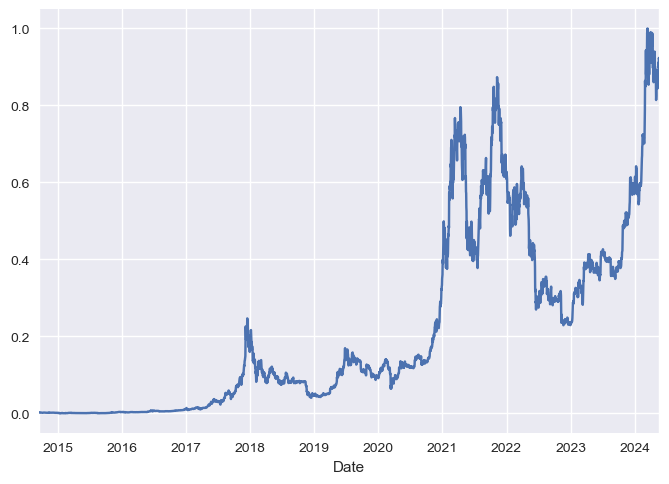

In [70]:
((hist['Close']-hist['Close'].min())/ (hist['Close'].max()-hist['Close'].min())).plot()

plt.show()

### RSI 

In [88]:
def calculate_rsi(data, window=14):
    
    # Calculate price changes
    delta = data.diff()

    # Separate positive and negative gains
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)

    # Calculate the average gain and loss
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    # Calculate the RS (Relative Strength)
    rs = avg_gain / avg_loss

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))

    return rsi


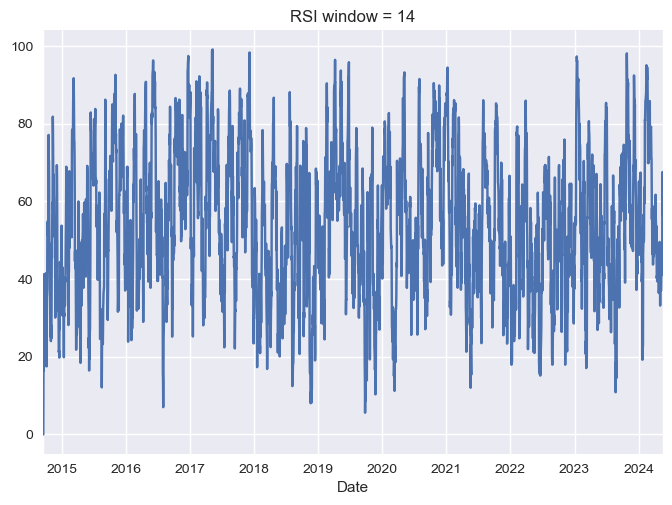

In [96]:
rsi_window = 14
plt.title(f'RSI window = {rsi_window}')
calculate_rsi(hist['Close'],window=rsi_window).plot()
plt.show()

### Bollinger Bands

In [97]:
def calculate_bollinger_bands(data, window=20, num_std_dev=2):
    # Calculate the Simple Moving Average (middle band)
    middle_band = data.rolling(window=window).mean()

    # Calculate the rolling standard deviation
    rolling_std = data.rolling(window=window).std()

    # Calculate the upper and lower bands
    upper_band = middle_band + (rolling_std * num_std_dev)
    lower_band = middle_band - (rolling_std * num_std_dev)

    return middle_band, upper_band, lower_band

In [162]:
middle_band, upper_band, lower_band = calculate_bollinger_bands(hist['Close'])

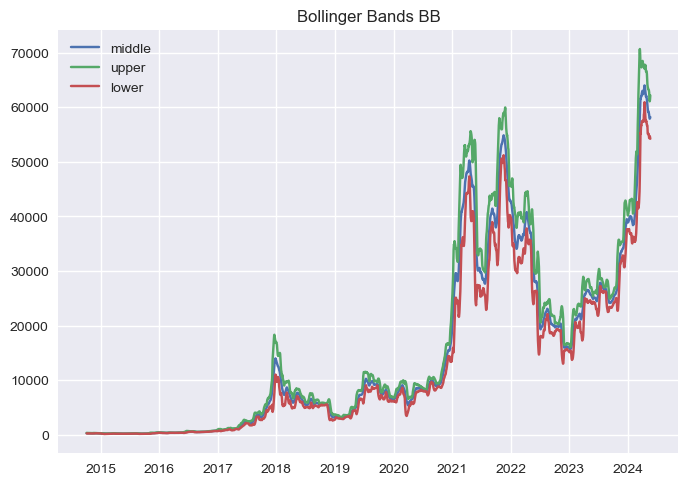

In [168]:
plt.title('Bollinger Bands BB')
plt.plot(middle_band, label = 'middle')
plt.plot(upper_band, label = 'upper')
plt.plot(lower_band, label = 'lower')
plt.legend()
plt.show()

### Fibonacci Retracement

In [103]:
def calculate_fibonacci_retracement(data, high=None, low=None):
    if high is None:
        high = data.max()
    if low is None:
        low = data.min()

    diff = high - low
    levels = {
        '0%': high,
        '23.6%': high - 0.236 * diff,
        '38.2%': high - 0.382 * diff,
        '50%': high - 0.5 * diff,
        '61.8%': high - 0.618 * diff,
        '100%': low
    }

    return levels

In [104]:
calculate_fibonacci_retracement(hist['Close'])

{'0%': 66723.8515625,
 '23.6%': 51012.69458648682,
 '38.2%': 41293.08052505493,
 '50%': 33437.50203704834,
 '61.8%': 25581.92354904175,
 '100%': 151.1525115966797}

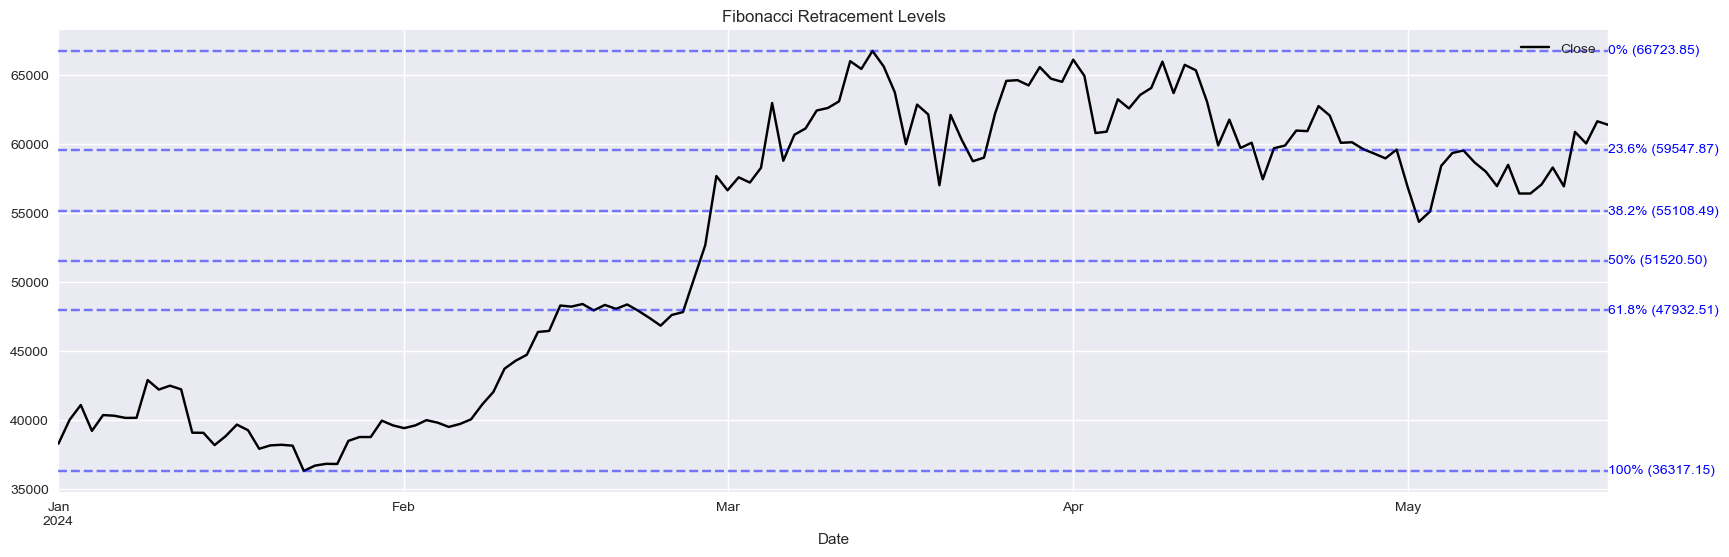

In [107]:
# Calculate Fibonacci retracement levels
levels = calculate_fibonacci_retracement(mask['Close'])

# Plot the closing prices and Fibonacci levels
plt.figure(figsize=(20, 6))
mask['Close'].plot(label='Close', color='black')

# Plot Fibonacci levels and add annotations
for level, value in levels.items():
    plt.axhline(value, linestyle='--', alpha=0.5, color='blue')
    plt.text(mask.index[-1], value, f'{level} ({value:.2f})', 
             horizontalalignment='left', verticalalignment='center', fontsize=10, color='blue')

plt.legend()
plt.title('Fibonacci Retracement Levels')
plt.show()

- **0%**: Starting point of the movement.
- **23.6%**: The ratio obtained by dividing a Fibonacci number by the number three positions later in the sequence (e.g., 21/89 ≈ 0.236).
- **38.2%**: The ratio obtained by dividing a Fibonacci number by the number two positions later in the sequence (e.g., 21/55 ≈ 0.382).
- **50%**: A midpoint often used by traders.
- **61.8%**: The ratio obtained by dividing a Fibonacci number by the next number in the sequence (e.g., 21/34 ≈ 0.618).
- **100%**: Ending point of the movement.

In [147]:
def fibonacci(n):
    u_n_1 = 0
    u = 1
    
    fibo = [u_n_1 , u]
    
    for n in range(2, n):
        v = u + u_n_1
        
        u_n_1 = u 
        u = v
        
        fibo.append(v)
    return fibo 

def generate_ratio(fib_sequence , rank):
    return [fib_sequence[i] / fib_sequence[i + rank] if i + rank < len(fib_sequence) else None for i in range(2,len(fib_sequence))]
    

In [159]:
fib_sequence = fibonacci(20)

In [160]:
ratios = {
    '23.6%': generate_ratio(fib_sequence , 3),
    '38.2%': generate_ratio(fib_sequence , 2),
    '61.8%': generate_ratio(fib_sequence , 1) 
}

In [161]:
ratios

{'23.6%': [0.2,
  0.25,
  0.23076923076923078,
  0.23809523809523808,
  0.23529411764705882,
  0.23636363636363636,
  0.23595505617977527,
  0.2361111111111111,
  0.23605150214592274,
  0.23607427055702918,
  0.2360655737704918,
  0.23606889564336372,
  0.23606762680025048,
  0.23606811145510836,
  0.23606792633341306,
  None,
  None,
  None],
 '38.2%': [0.3333333333333333,
  0.4,
  0.375,
  0.38461538461538464,
  0.38095238095238093,
  0.38235294117647056,
  0.38181818181818183,
  0.38202247191011235,
  0.3819444444444444,
  0.38197424892703863,
  0.3819628647214854,
  0.3819672131147541,
  0.3819655521783181,
  0.38196618659987475,
  0.38196594427244585,
  0.38196603683329344,
  None,
  None],
 '61.8%': [0.5,
  0.6666666666666666,
  0.6,
  0.625,
  0.6153846153846154,
  0.6190476190476191,
  0.6176470588235294,
  0.6181818181818182,
  0.6179775280898876,
  0.6180555555555556,
  0.6180257510729614,
  0.6180371352785146,
  0.6180327868852459,
  0.6180344478216818,
  0.6180338134001252,

# Conclusion 

In trading we can use various indicators based on our asset price, those indicators help us to caracterise the volatility of this one,
each indicators has its own parameter that we need to optimize